In [1]:
import os

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import subprocess

from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky
from astropy.io.fits.header import Header
from astropy.modeling import models, fitting
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ZScaleInterval
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astroquery.gaia import Gaia
from ccdproc import CCDData
from photutils import DAOStarFinder
from threading import Timer


from goodman_pipeline.core import ra_dec_to_deg
from goodman_pipeline.core import SaturationValues

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


Failed to import any qt binding


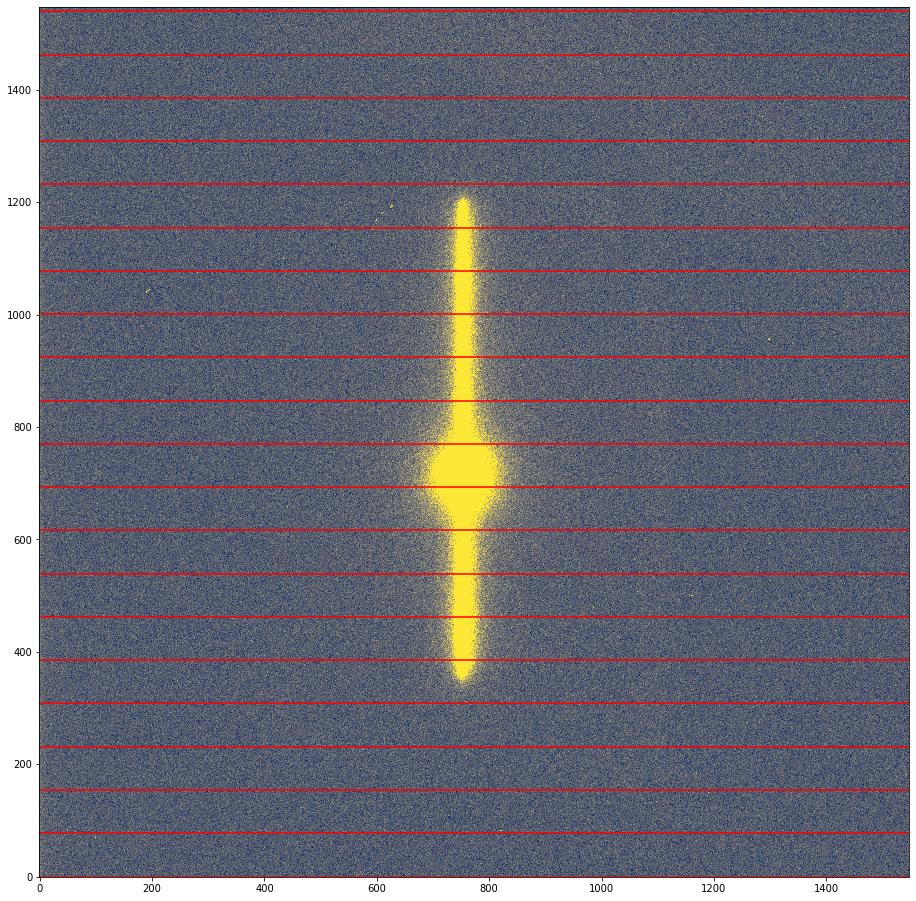

In [71]:
mask_file = "data/case_1/0348_SN2020uxz-23-10-2020_mask_in.fits"
mask_file = "data/case_2/0358_REFITT-ZTF20ackfpcb-09-11-2020_mask_in.fits"

ccd = CCDData.read(mask_file, unit='adu')
mean, median, std = sigma_clipped_stats(ccd.data, sigma=3.0)

fig, ax = plt.subplots(figsize=(16, 16))
scale = ZScaleInterval()
ax.imshow(ccd.data, clim=scale.get_limits(ccd), origin='lower', cmap='cividis')
y = ccd.data.shape[1]

for i in range(0, y, int(0.05 * y)):
    ax.axhline(i, color='r')

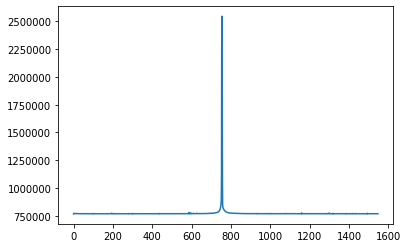

In [37]:
profile = np.sum(ccd.data, axis=0)

fig2 , ax2 = plt.subplots()

ax2.plot(profile)

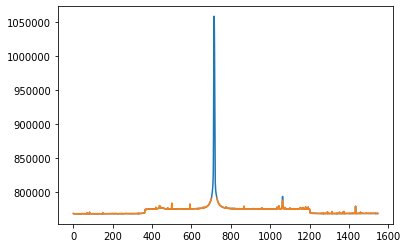

In [38]:
from astropy.stats import sigma_clip


max_profile = np.sum(ccd.data, axis=1)

sigma_clipped = sigma_clip(max_profile, sigma=1, maxiters=1, cenfunc=np.ma.median)

fig2 , ax2 = plt.subplots() #figsize=(16,16))

ax2.plot(max_profile)
ax2.plot(sigma_clipped)

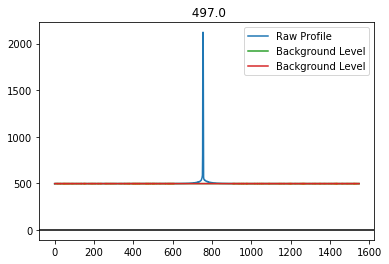

[754]
[1625.]


In [45]:
from goodman_focus.goodman_focus import get_peaks
from scipy import signal


peaks, values, x_axis, profile = get_peaks(ccd, plots=True)
print(peaks)
print(values)

(0, 1500)

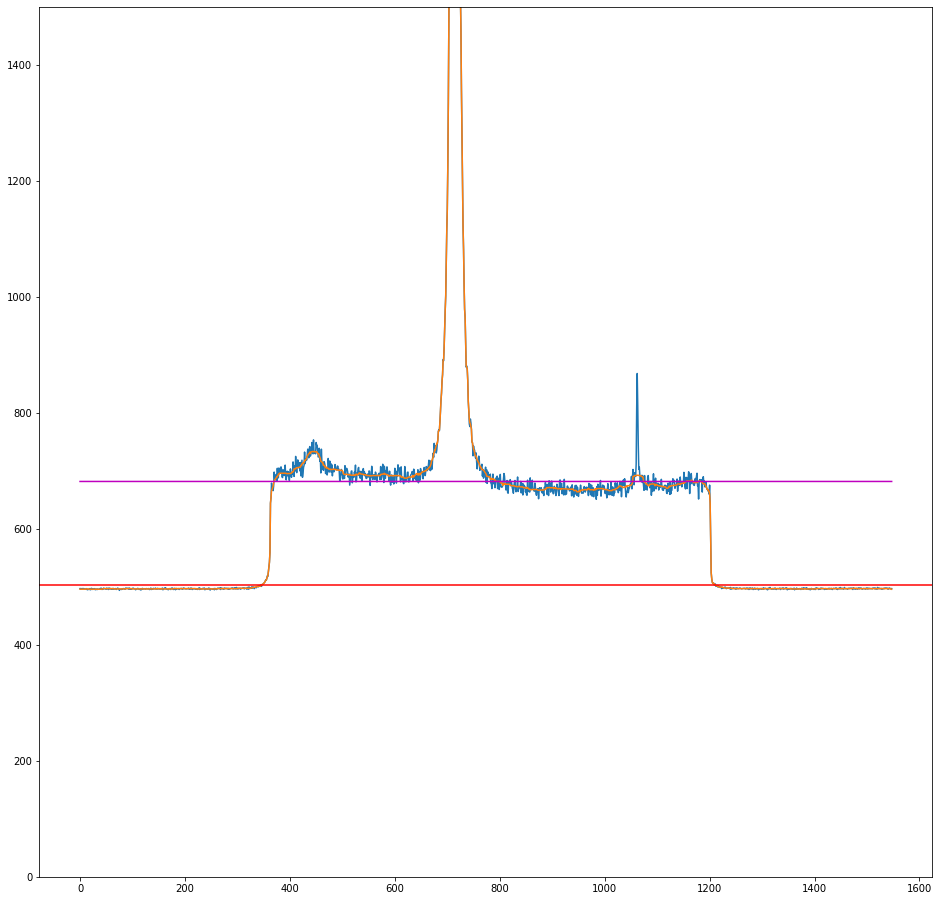

In [59]:
fig, ax = plt.subplots(figsize=(16,16))
p = peaks[0]
slit_area = ccd.data[:,p-5:p+5]
slit = np.median(slit_area, axis=1)
filtered_slit = signal.medfilt(slit, kernel_size=21)
x, y = ccd.data.shape

box_model = models.Box1D(amplitude=700, x_0=int(y/2.), width=y/2.)
box_fitter = fitting.SimplexLSQFitter()

fitted_box = box_fitter(box_model, range(y), slit)
ax.plot(slit, label='Slit')
ax.plot(filtered_slit, label='Median Filtered')
ax.plot(fitted_box(range(y)), color='m', label='Fitted box')
ax.axhline(median + 3 * std, color='r')
ax.set_ylim(0, 1500)